# Metric Forecasting: Server Load Prediction

**Author:**  

Pavel Grigoryev

**Project Description:**

- Recently, we've been receiving increasing complaints about application lag and performance issues. 
- As user activity grows, server load intensifies, requiring proactive capacity planning. 
- While this is primarily a DevOps and engineering challenge, accurate forecasting of user activity is crucial for anticipating server demands and preventing future performance degradation.

**Project Goal:**

- To build reliable forecasting models that predict user activity patterns for the upcoming month, enabling proactive server capacity planning and preventing application performance issues.
   
**Data Sources:**

- `feed_actions` - News feed activity
- `message_actions` - Messaging activity 

**Implementation Summary:**

- **Metric Selection & Analysis:** 
  - Selected total actions (feed + messenger) as primary load metric and total DAU as stability metric; conducted comprehensive EDA on 2 months of historical data
- **Model Development & Validation:**
  -  Tested ETS, LGT, DLT, and KTR models with multiple estimators; performed rigorous backtesting with expanding and rolling windows
- **Parameter Optimization & Quality Assessment:** 
  - Conducted grid search for optimal model parameters; evaluated models using SMAPE, MAE, and information criteria
- **Forecasting Strategy:** 
  - Established 7-day forecasting as optimal horizon given data constraints; identified key limitations and model interpretation guidelines

**Main Conclusion**

Total DAU Forecasting

- **Best Model:** 
  - DLT with MAP estimator, linear trend, no regressors or regularization
- **Accuracy:** 
  - 3.9% SMAPE error (excellent result given limited data)
- **Key Insight:** 
  - Linear trend outperforms log-linear
  - MAP estimators work better than MCMC with small datasets

Total Actions Forecasting  
- **Best Model:** 
  - DLT with MAP estimator, linear trend, no regressors
- **Accuracy:** 
  - 21.4% SMAPE error (reasonable given metric volatility)
- **Key Insight:** 
  - Total actions are more volatile but crucial for server load planning

**Key Recommendations**

Immediate Actions
- Implement weekly forecasting using the selected DLT models for both metrics
- Use total DAU for stable capacity planning and total actions for peak load estimation
- Maintain separate forecasts for feed and messenger components

Strategic Recommendations
- **Data Collection:** 
  - Continue accumulating historical data for improved model accuracy
- **Model Retraining:** 
  - Schedule monthly model re-evaluation as data volume increases
- **Gradual Expansion:** 
  - Consider extending forecast horizon to 2 weeks once 3+ months of data are available

# Loading Libraries

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import orbit
from orbit.eda import eda_plot
from orbit.models import DLT, ETS, LGT, KTR 
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_bt_predictions
from orbit.diagnostics.metrics import smape, wmape
from orbit.diagnostics.backtest import BackTester 
from orbit.utils.params_tuning import grid_search_orbit 
import arviz as az 
from tqdm.auto import tqdm
import plotly.express as px
from matplotlib import pyplot as plt
sys.path.append('../../assets')
import plotly_config 
import sql_config
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format
%load_ext sql
%sql $sql_config.connection_string
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
%config SqlMagic.autopandas = True
plt.rcParams.update({
    'font.size': 8,         
    'axes.titlesize': 10,    
    'axes.labelsize': 9,     
    'xtick.labelsize': 8,    
    'ytick.labelsize': 8,    
    'legend.fontsize': 8,    
    'figure.titlesize': 10   
})

# Data Description

The data is located in ClickHouse tables `feed_actions` and `message_actions`.

Table feed_actions

Field | Description
-|-
user_id | User ID
post_id | Post ID
action | Action: view or like
time | Timestamp
gender | User's gender
age | User's age (1 = Female)
country | User's country
city | User's city
os | User's OS
source | Traffic source
exp_group | A/B test group

Table message_actions

Field | Description
-|-
user_id | Sender's ID
receiver_id | Receiver's ID
time | Send timestamp
source | Sender's traffic source
exp_group | Sender's A/B test group
gender | Sender's gender
age | Sender's age (1 = Male)
country | Sender's country
city | Sender's city
os | Sender's OS

# Research Design

**Selection of Primary Metric and Justification**

- As the primary metric, we choose **number of actions in the feed + number of messages in the messenger**
- As the auxiliary metric, we choose **total DAU**

Justification:

- Server load will depend on the total activity in the feed and messenger.
- To determine activity, we could choose the number of unique users, but one user can perform many actions and send many messages that will load the server, which we wouldn't account for.
- The optimal choice is the daily total value of feed actions and messenger messages.
- We will account for both users and their activity. The more actions they perform and messages they send, the higher this total metric will be.
- However, since total activity can vary significantly, it's better to also forecast total DAU for feed and messenger.
- After all, forecast quality is important, and I think DAU quality will be better as it's more stable.
- Considering both forecasts will allow for more accurate prediction of how user activity will change.
- DAU will be calculated separately for feed and messenger, then summed, as it's desirable to account for load on both services.

**Will There Be Regressors**

- Since we don't have metrics whose future values we know, using other metrics as regressors is ineffective.
- However, since we'll be forecasting DAU, we'll try adding DAU as a regressor in several models and compare with other models.
- As a regressor, we can choose the weekend factor.
    - Since user behavior on weekends may differ from weekdays.
    - But first we need to confirm this is visible on the charts.
- We'll also choose the flash mob day factor as a regressor.
    - Set these days to 1, others to 0.
    - If we knew a flash mob would occur in the future, we could set 1 for the relevant days.
    - We'll also consider August 23, 2025 as a flash mob, as charts show increased activity on that day.
- We also know that on August 15, 2025 there was an advertising campaign, and on August 24 there was an activity drop due to technical issues in major cities.
    - For these dates, we'll also set 1 to account for these anomalous dates.
    - For future advertising campaigns, we can set 1 for the advertising campaign factor.
- It would also be desirable to use holidays as regressors.
    - But adding a regressor without studying how our metric behaved on such days is not ideal.
    - And since we haven't had holidays in our history, we won't create such a regressor.

**Temporal Resolution (Granularity)**

- Primary resolution: Day (Daily)
- Balance between noise and detail: Hourly data would be too noisy (spikes at lunch, drops at night).

**Do We Have Enough Data for Backtesting with the Current Task?**

- No, we don't have enough data for proper backtesting on a monthly horizon.

**Forecasting Horizon Selection**

- We can choose a horizon of 7 or 14 days.
- To conduct good backtesting, a 1-week horizon is better.
- Since we have approximately 2 months of data, I think 7 days is the optimal choice.
- It's better to prioritize quality over longer forecast duration.
- For proper backtesting, the training size at each iteration should be at least 3 prediction horizons.
- In this case, for a 2-week forecast we'd only have 2 iterations, which is too few.
- If we choose a 7-day forecast, we'll have 6-7 backtest iterations, which is acceptable.
- When we accumulate enough data for at least 3 iterations, we can consider a 2-week forecast.

**Research Procedure**

- Load necessary data
- Study it and adjust regressors if needed
- Select models for analysis and their parameters
- Determine how we'll evaluate model quality
- Conduct analysis of selected models
- Select the best models (one for total DAU and one for total actions)
- For the best models, tune parameters using Grid search
- Make test forecasts
- Write conclusions and recommendations

# Data Loading

- Query ClickHouse and get the necessary data.
- We won't take the current day as it's incomplete.
- Save it to pandas DataFrames.
- Look at several rows of each DataFrame.
- Check column types.
- Set data types for columns where possible.

In [2]:
%%sql df <<
WITH feed_daily as (
    SELECT
        toDate(time) as date
        , count() as total_feed_actions
        , uniq(user_id) as feed_users
    FROM
        feed_actions
    WHERE
        date < toDate(now())
    GROUP BY
        date
)
, mess_daily as (
    SELECT
        toDate(time) as date
        , count() as total_mess_actions
        , uniq(user_id) as mess_users
    FROM
        message_actions
    WHERE
        date < toDate(now())
    GROUP BY
        date
)
SELECT
    if(f.date != toDate(0), f.date, m.date) as date
    , toDayOfWeek(date) as day_of_week
    , if(toDayOfWeek(date) in (6, 7), 1, 0) as is_weekend
    , if(toDayOfWeek(date) = 5, 1, 0) as is_friday
    , date BETWEEN '2025-08-16' AND '2025-08-23' as is_flashmob
    , date = '2025-08-15' as is_ads_company
    , date = '2025-08-24' as is_drop_down
    , f.total_feed_actions + m.total_mess_actions as actions
    , f.feed_users + m.mess_users as users
FROM
    feed_daily f
    FULL JOIN mess_daily m ON f.date = m.date
ORDER BY
    date

Returning data to local variable df


In [3]:
df.head(3)

,date,day_of_week,is_weekend,is_friday,is_flashmob,is_ads_company,is_drop_down,actions,users
0,2025-07-06,7,1,0,0,0,0,12389,1112
1,2025-07-07,1,0,0,0,0,0,88481,2861
2,2025-07-08,2,0,0,0,0,0,139381,3627


In [4]:
df.dtypes

date              object
day_of_week        int64
is_weekend         int64
is_friday          int64
is_flashmob        int64
is_ads_company     int64
is_drop_down       int64
actions            int64
users              int64
dtype: object

In [5]:
df['date'] = pd.to_datetime(df['date'])

# Data Exploration

- We know that from 2025-08-16 to 2025-08-22 there was a flash mob.
- If we chose the metric correctly, it should have shown up during this time.
- Let's verify this.

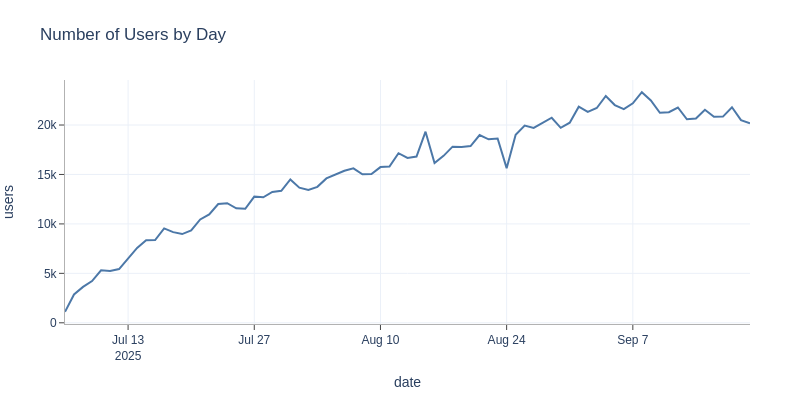

In [6]:
px.line(
    df
    , x='date'
    , y='users'
    , width=800
    , title='Number of Users by Day'
)

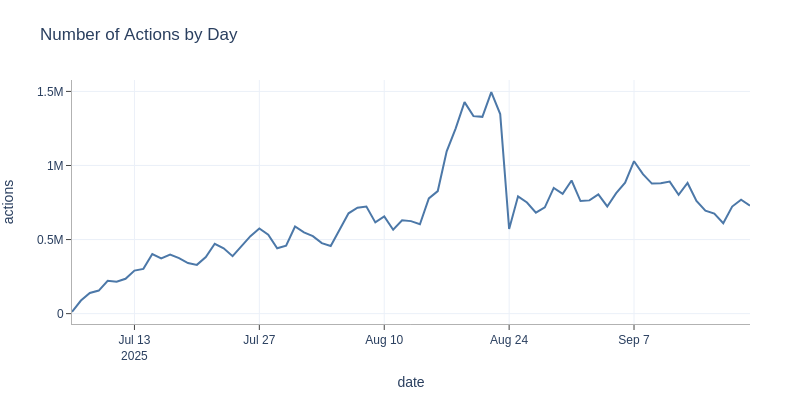

In [7]:
px.line(
    df
    , x='date'
    , y='actions'
    , width=800
    , title='Number of Actions by Day'
)

**Observations:**

- Our total activity metric clearly showed a spike during the flash mob days.
- This means the choice was correct.
- We can also see that total number of users behaves more stably than total activity.

Let's check if there's weekly seasonality.

**Let's examine by whether it's a weekend day**

Mean

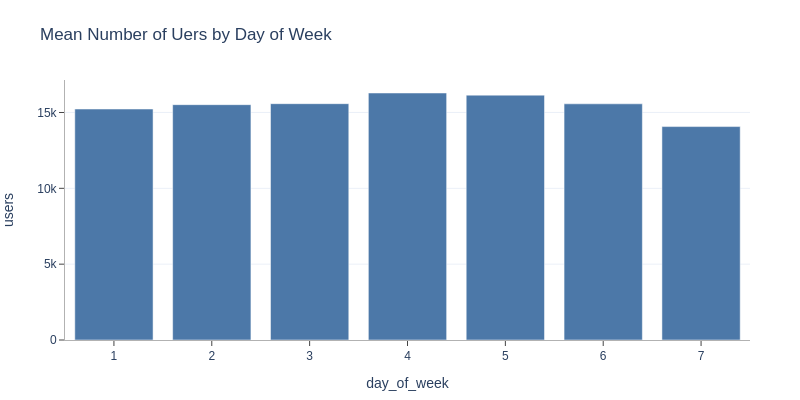

In [8]:
px.bar(
    df.groupby('day_of_week', as_index=False)['users'].mean()
    , x='day_of_week'
    , y='users'
    , width=800
    , title='Mean Number of Uers by Day of Week'
)

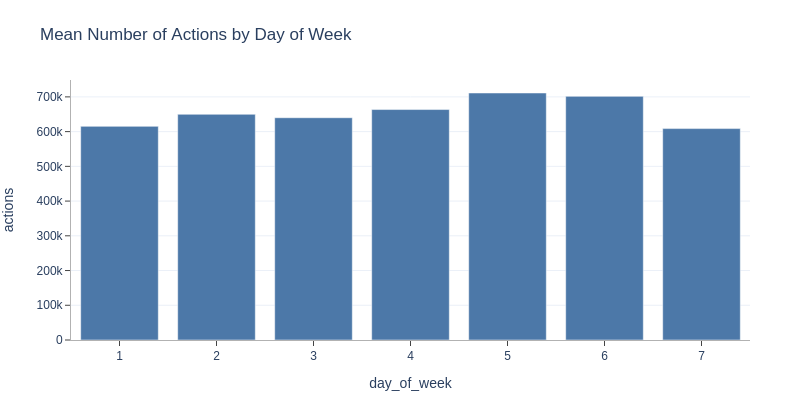

In [9]:
px.bar(
    df.groupby('day_of_week', as_index=False)['actions'].mean()
    , x='day_of_week'
    , y='actions'
    , width=800
    , title='Mean Number of Actions by Day of Week'
)

Median

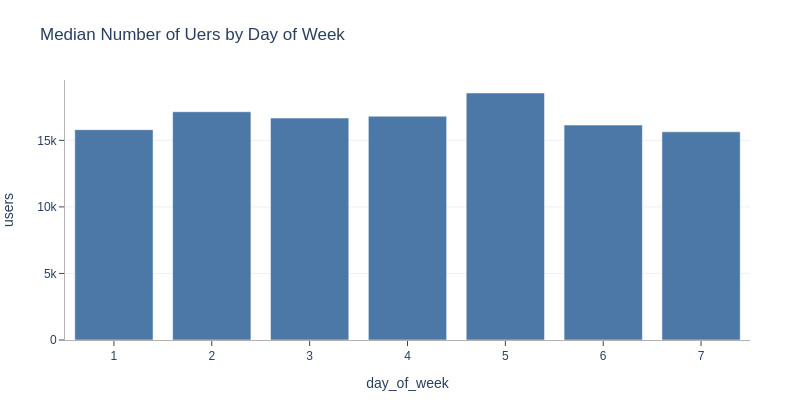

In [10]:
px.bar(
    df.groupby('day_of_week', as_index=False)['users'].median()
    , x='day_of_week'
    , y='users'
    , width=800
    , title='Median Number of Uers by Day of Week'
)

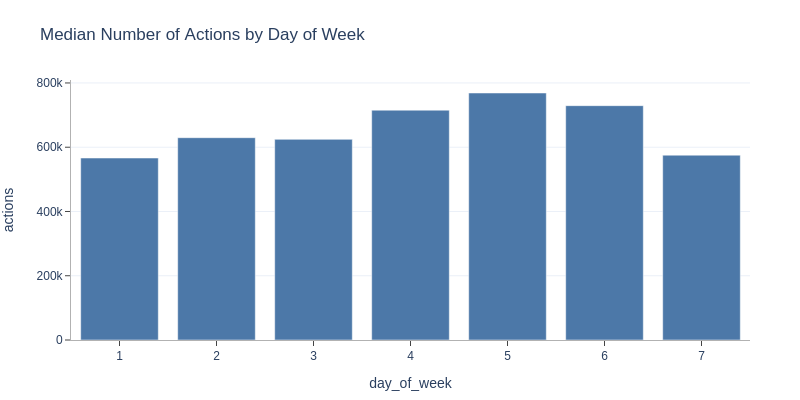

In [11]:
px.bar(
    df.groupby('day_of_week', as_index=False)['actions'].median()
    , x='day_of_week'
    , y='actions'
    , width=800
    , title='Median Number of Actions by Day of Week'
)

**Observations:**

- Friday and Saturday stand out with higher total activity, while Monday and Sunday have lower activity.

Let's examine excluding the flash mob.

In [12]:
mask = ~df.date.between('2025-08-16', '2025-08-23')

In [13]:
df_for_fig = (
    df[mask]
    .groupby('day_of_week', as_index=False)['actions']
    .median()
)

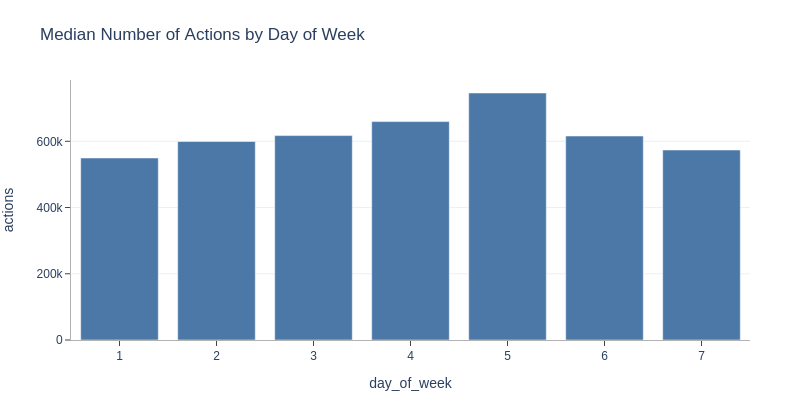

In [14]:
px.bar(
    df_for_fig
    , x='day_of_week'
    , y='actions'
    , width=800
    , title='Median Number of Actions by Day of Week'
)

**Observations:**

- Friday clearly stands out.

Let's look at the heatmap.

In [ ]:
ax, _, _ = eda_plot.ts_heatmap(df=df, date_col="date", value_col="users", seasonal_interval=7, normalization=False)
plt.close()

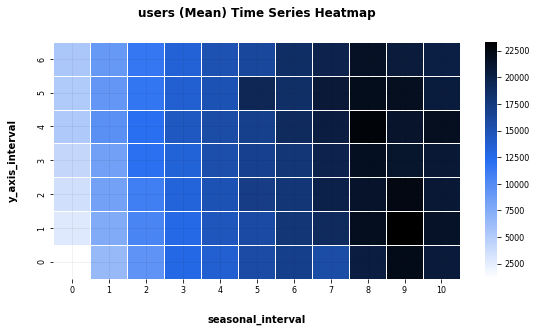

In [16]:
fig = ax.get_figure()
fig.set_size_inches(8, 4)
fig

In [ ]:
ax, _, _ = eda_plot.ts_heatmap(df=df, date_col="date", value_col="actions", seasonal_interval=7, normalization=False)
plt.close()

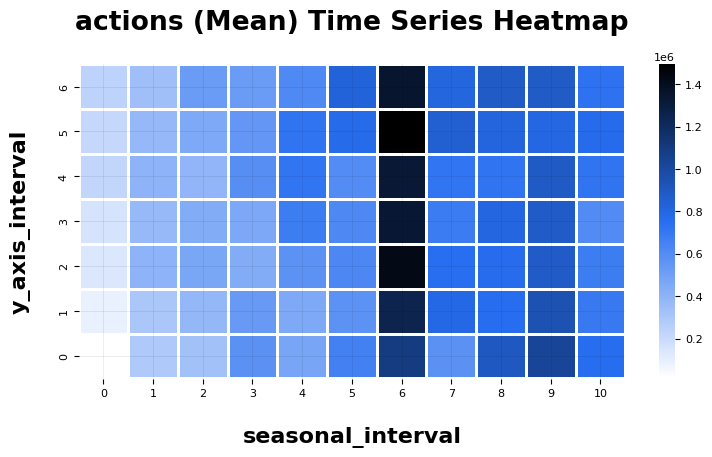

In [18]:
fig = ax.get_figure()
fig.set_size_inches(8, 4)
fig

Let's examine the medians.

In [19]:
df_for_fig = (
    df.pivot_table(
        index='day_of_week'
        , columns=pd.Grouper(key='date', freq='7d')
        , aggfunc='median'
    )['users']
)

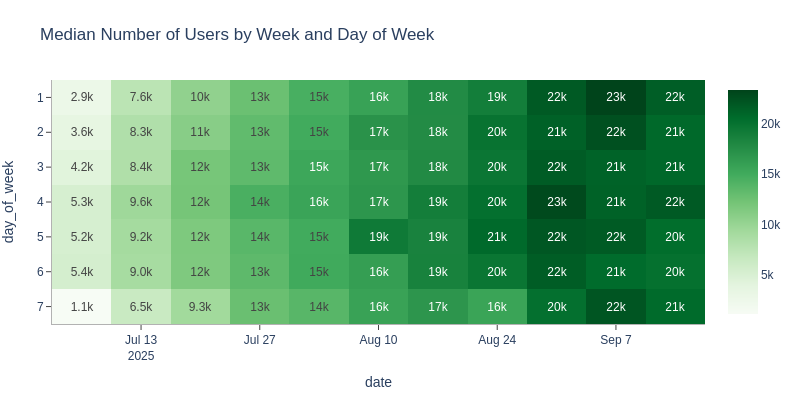

In [20]:
px.imshow(
    df_for_fig
    , color_continuous_scale='Greens'
    , title='Median Number of Users by Week and Day of Week'
    , width=800
    , text_auto='.2s'
)

In [21]:
df_for_fig = (
    df.pivot_table(
        index='day_of_week'
        , columns=pd.Grouper(key='date', freq='7d')
        , aggfunc='median'
    )['actions']
)

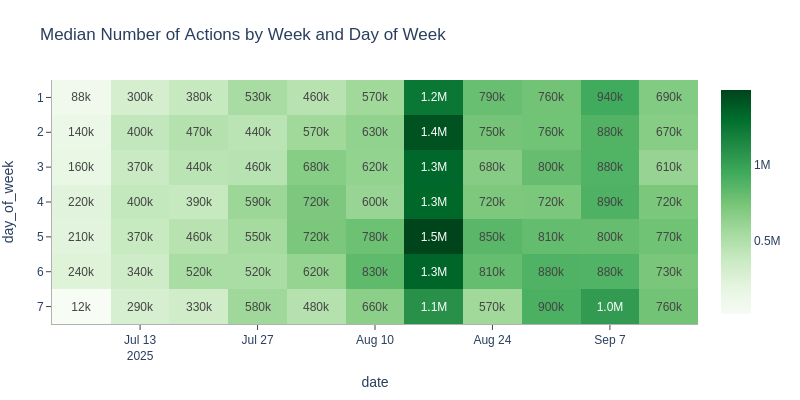

In [22]:
px.imshow(
    df_for_fig
    , color_continuous_scale='Greens'
    , title='Median Number of Actions by Week and Day of Week'
    , width=800
    , text_auto='.2s'
)

**Observations:**

- Although Friday stands out in overall mean and median, no seasonality is observed when broken down by day of week and week.
- Therefore, we won't add seasonality as it would complicate the model when there's no explicit seasonality.
- Regarding Friday, the choice is difficult - on one hand, it stands out only by day of week, but when broken down by both day of week and week, there's no clear difference.
- We won't add the weekend day factor as this hypothesis wasn't confirmed.

**Let's examine correlation**

Pearson

In [23]:
df[['actions', 'users', 'is_weekend', 'is_friday', 'is_flashmob']].corr()

,actions,users,is_weekend,is_friday,is_flashmob
actions,1.000,0.769,-0.001,0.074,0.679
users,0.769,1.000,-0.075,0.048,0.142
is_weekend,-0.001,-0.075,1.000,-0.258,0.067
is_friday,0.074,0.048,-0.258,1.000,-0.017
is_flashmob,0.679,0.142,0.067,-0.017,1.000


Spearman

In [24]:
df[['actions', 'users', 'is_weekend', 'is_friday', 'is_flashmob']].corr(method="spearman")

,actions,users,is_weekend,is_friday,is_flashmob
actions,1.000,0.839,0.036,0.082,0.511
users,0.839,1.000,-0.078,0.045,0.092
is_weekend,0.036,-0.078,1.000,-0.258,0.067
is_friday,0.082,0.045,-0.258,1.000,-0.017
is_flashmob,0.511,0.092,0.067,-0.017,1.000


Kendall

In [25]:
df[['actions', 'users', 'is_weekend', 'is_friday', 'is_flashmob']].corr(method="kendall")

,actions,users,is_weekend,is_friday,is_flashmob
actions,1.000,0.667,0.030,0.067,0.420
users,0.667,1.000,-0.064,0.037,0.076
is_weekend,0.030,-0.064,1.000,-0.258,0.067
is_friday,0.067,0.037,-0.258,1.000,-0.017
is_flashmob,0.420,0.076,0.067,-0.017,1.000


**Observations:**

- Total number of actions and total number of users correlate well.
- Flash mob factor correlates reasonably well with our metric.
- Friday factor hardly correlates at all. Therefore, we won't use Friday factor as a regressor.
- Similarly, we won't use weekend day factor as a regressor.

# Model Definition and General Settings

## General Settings

Ultimately, we will use:
- Primary metric: **total number of actions in feed and messenger**
- Additional metric: **total DAU**
- Granularity: **1 day**
- Seasonality: **will not be considered**
- Regressors will be:
    - flash mob factor
    - advertising campaign factor
    - activity drop factor in major cities
    - for the primary metric, we'll try adding total DAU as a regressor
- Forecast horizon: **7 days**

Save the required column names in variables.

In [26]:
date_col = 'date'               
n_bootstrap_draws=1000          
regressor_cols = ['is_flashmob', 'is_ads_company', 'is_drop_down']   

## Model Types

ETS - Exponential Smoothing

- Model with exponential smoothing
- Simplest forecasting model giving more weight to recent values and less to older ones.
- Can only estimate overall level and seasonality
- Does not support trend and additional regressors.
- In Orbit, it serves more as a training function since other models are more advanced.

LGT - Local Global Trend

- Model with local and global trends
- Models both local trends (short-term changes) and global trends (characteristic of the entire dataset).
- Only works with positive data.

DLT - Damped Local Trend

- Model with damped local trend
- Allows additional regressors and trend.
- Similar to LGT but structured slightly differently and allows negative values.
- Also has a damping parameter that reduces local trend values, thus giving more weight to global changes.

KTR - Kernel-based Time-varying Regression

- More complex and experimental model.
- Allows specifying multiple seasonality (e.g., daily and weekly)
- Works more flexibly with regressors, has lower computational costs.
- There's a simpler version KTRLite with fewer tunable parameters and a simpler estimation algorithm.

**Which Models We'll Choose**

- We'll choose all models to test different options.

## Estimators

- **Estimator** in the context of Orbit and statistical modeling is an algorithm or method used to train a model and estimate its parameters.
- Simply put: it's the "engine" that finds the best values for all coefficients in our model (trend, seasonality, regressors) so the model describes our data as accurately as possible.

In Orbit, the following estimators exist:

- **'stan-map'** (Maximum a Posteriori)
    - Fastest, point estimation of parameters. Good for rapid prototyping.
    - What it does: Finds the single best set of parameters.
    - Analogy: Looks for the highest mountain peak (maximum of distribution).
    - Disadvantages: Provides only point estimates, without full uncertainty distribution.

- **'stan-mcmc'** (Markov Chain Monte Carlo)
    - Full Bayesian inference, slowest but most accurate for uncertainty estimation.
    - What it does: Generates multiple possible parameter sets according to their distribution.
    - Analogy: Explores the entire mountain range, not just the peak.
    - Disadvantages: Very slow, requires lots of data, may have convergence issues.

- **'stan-vi'** (Variational Inference)
    - Faster than MCMC, but still provides distribution.
    - What it does: Approximates posterior distribution with a simpler distribution.
    - Analogy: Looks for a "similar" mountain that's easier to describe mathematically.
    - Advantages: Faster than MCMC but provides distribution (not just point).
    - Disadvantages: Approximation may be less accurate than MCMC.

**Which estimators we'll choose**

- We'll choose all estimators to test different options.

## Model Quality Evaluation

As we know, in machine learning, model quality is evaluated in three main ways:

- **Train-test split**
    - train the model on the first set
    - test how well it predicts on the second set
- **Cross-validation**
    - like the previous method, but the dataset is split into train and test in multiple ways
- **Combination of the two above**
    - separate test set, perform cross-validation on train, then additionally test the model on test set

However, in the classical version, these approaches don't work for time series
- because our observations are not independent but connected through time.
- This must be accounted for - and in Orbit this is implemented through the concept of **backtesting**.

Backtesting in Orbit is implemented in two different variants:

- **Expanding window**
    - Starts with a small training data size and gradually increases it until data runs out.
    - This allows evaluating how prediction accuracy changes with increasing information.
    - This window type works best if data isn't too volatile and there's important information in the distant past useful for future prediction.

- **Rolling window**
    - In rolling, the training data size doesn't change - it shifts over time.
    - This variant is useful if our data is volatile and the main prediction information is in the recent past.

**Information Criteria**
- Information criteria - a measure of relative model quality.
- Their task is to select the model with maximum predictive capability and minimum predictors.
- We can use them to choose the best model.

Main information criteria:

- **AIC** (Akaike Information Criterion)
    - Penalizes for model complexity
- **BIC** (Bayesian Information Criterion)
    - Penalizes for complexity more strongly than AIC, especially with large n

How to interpret:
- The **LOWER** the criterion value - the **BETTER** the model

**Model Quality Metrics**

- **Mean Squared Error (mse)**
  - average squared errors
  - sum of squared deviations of predicted values from actual divided by number of observations

- **Mean Absolute Error (mae)**
  - mean absolute error
  - like previous but uses absolute value instead of square
  - compared to previous metric, this gives less weight to anomalously incorrect predictions (e.g., data outliers)

- **Root Mean Squared Scaled Error (rmsse)**
  - similar to MSE but with additional feature
  - shows how much worse our model is than if we simply guessed based on previous values

- **Mean Absolute Percentage Error (mape)**
  - similar to MAE but expressed as fractions of the true value
  - easily interpreted but has major drawback - metric is biased toward models that "underpredict" and penalizes models with "overprediction"

- **Symmetric Mean Absolute Percentage Error (smape)**
  - corrected version of previous metric so underpredictions have same weight as overpredictions
  - symmetric version of MAPE. Error relative to average of actual and forecast values.

- **Weighted Mean Absolute Percentage Error (wmape)**
  - weighted version of MAPE
  - each observation is given additional specific weight by which the "contribution" of particular observation is evaluated - in Orbit, greater weight is given to largest absolute observations relative to time series
  - weighted average error. Shows proportion of total error relative to total data volume.

- **Weighted Symmetric Mean Absolute Percentage Error (wsmape)**
  - combination of the two previous points

**How we'll check model quality**

- We'll train models in a loop
- Save their bic (for map) and wbic (for others)
- Save plots for mcmc models for obs_sigma parameter
    - this is important because if mcmc model doesn't converge, its estimates are incorrect
    - Visually, the plot should look like 4 time series jumping around approximately the same value
    - This means different algorithm instances arrived at the same conclusion regarding parameters!
- For each model, conduct backtesting and save metrics
    - we'll conduct backtesting for both expanding and rolling windows
- Finally, build plots for mcmc and examine backtesting metrics
- We'll use smape rolling backtest as the main quality metric
    - Rolling backtest more accurately evaluates the model as it considers a specific window
    - Expanding may average errors over the entire period

## Regularization

- Very often, to solve overfitting problems, ML specialists resort to **regularization** technique
- This is applying additional penalties to model coefficients so they don't become too large, especially if the regressor is poor.

Main types of regularization:

- **L1-regularization (Lasso):**
    - Adds sum of absolute weights to loss function
    - Promotes zeroing of unnecessary weights, allowing selection of only important features
    - Simplifies model, which may save resources

- **L2-regularization (Ridge):**
    - Adds sum of squared weights to loss function
    - Reduces influence of large weights, smoothing peaks in activation function
    - Helps avoid overfitting while maintaining all features

In Orbit, `fixed_ridge` is used by default.

**How we'll do regularization**

- For some models, we'll add variants with auto_ridge and lasso regularization
- This will help understand if regularization helps

## Parameter Selection for Backtesting

- Since we're forecasting for a week (7 days), we'll choose the smallest data chunk to start training as 28 (4 × 7)
- I think this will be the optimal balance between number of iterations and minimum data chunk.

Set backtest parameters

In [27]:
backtest_params = {
    'min_train_len': 4 * 7,
    'incremental_len': 7,
    'forecast_len': 7
}

## Model Definition

We'll test the following models:

- **ETS**
    - with estimator stan-map without regressors and trend
    - with estimator stan-mcmc without regressors and trend

- **LGT**
    - with estimator stan-map without regressors
    - with estimator stan-mcmc without regressors
    - with estimator stan-map with regressors
    - with estimator stan-mcmc with regressors

- **DLT**
    - with estimator stan-map without regressors and with linear trend
    - with estimator stan-map without regressors and with loglinear trend
    - with estimator stan-mcmc without regressors and with linear trend
    - with estimator stan-mcmc without regressors and with linear trend and with auto_ridge regularization
    - with estimator stan-mcmc without regressors and with linear trend and with lasso regularization
    - with estimator stan-mcmc without regressors and with loglinear trend
    - with estimator stan-map with regressors and with linear trend
    - with estimator stan-map with regressors and with linear trend and with auto_ridge regularization
    - with estimator stan-map with regressors and with linear trend and with lasso regularization
    - with estimator stan-map with regressors and with loglinear trend
    - with estimator stan-mcmc with regressors and with linear trend
    - with estimator stan-mcmc with regressors and with linear trend and with auto_ridge regularization
    - with estimator stan-mcmc with regressors and with linear trend and with lasso regularization
    - with estimator stan-mcmc with regressors and with loglinear trend

- **KTR**
    - with estimator pyro-svi without regressors
    - with estimator pyro-svi with regressors

For total number of actions, we'll additionally add models with DAU regressor:

- **DLT**
    - with estimator stan-map with regressors (+ DAU as regressor) and with linear trend
    - with estimator stan-map with regressors (+ DAU as regressor) and with linear trend and with auto_ridge regularization
    - with estimator stan-mcmc with regressors (+ DAU as regressor) and with linear trend

**How we'll define models**
- Each model takes up space and backtesters also take up space
- Simply creating models would be inefficient
- Better to create a config with all models
- If needed, we can run the required model separately
- Create a function to set configs for different metrics

## Creating Function for Model Configs

Create a function that will return model configs for different metrics.

In [ ]:
def get_models_config(response_col: str) -> dict:
    """Return model config for chosen metric"""
    base_params = {
        'response_col': response_col,
        'date_col': date_col,
    }

    models_config = {
        # ETS models
        'ets_map': {
            'model_class': ETS,
            'params': {
                **base_params,
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'ets_mcmc': {
            'model_class': ETS,
            'params': {
                **base_params,
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        # LGT models
        'lgt_map': {
            'model_class': LGT,
            'params': {
                **base_params,
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'lgt_mcmc': {
            'model_class': LGT,
            'params': {
                **base_params,
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        'lgt_map_reg': {
            'model_class': LGT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'lgt_mcmc_reg': {
            'model_class': LGT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        # DLT models
        'dlt_map_linear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'global_trend_option': 'linear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },      
        'dlt_map_loglinear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'global_trend_option': 'loglinear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'dlt_mcmc_linear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'global_trend_option': 'linear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        'dlt_mcmc_loglinear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'global_trend_option': 'loglinear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        'dlt_map_reg_linear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'dlt_map_reg_linear_ridge': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws,
                'regression_penalty': "auto_ridge"
            }
        },
        'dlt_map_reg_linear_lasso': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws,
                'regression_penalty': "lasso"
            }
        },        
        'dlt_map_reg_loglinear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'loglinear',
                'estimator': 'stan-map',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'dlt_mcmc_reg_linear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        'dlt_mcmc_reg_linear_ridge': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False},
                'regression_penalty': "auto_ridge"
            }
        },
        'dlt_mcmc_reg_linear_lasso': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'linear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False},
                'regression_penalty': "lasso"
            }
        },
        'dlt_mcmc_reg_loglinear': {
            'model_class': DLT,
            'params': {
                **base_params,
                'regressor_col': regressor_cols,
                'global_trend_option': 'loglinear',
                'estimator': 'stan-mcmc',
                'num_warmup': 10000,
                'num_sample': 10000,
                'stan_mcmc_args': {'show_progress': False}
            }
        },
        # KTR models
        'ktr': {
            'model_class': KTR,
            'params': {
                **base_params,
                'estimator': 'pyro-svi',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        },
        'ktr_reg': {
            'model_class': KTR,
            'params': {
                **base_params,
                'estimator': 'pyro-svi',
                'n_bootstrap_draws': n_bootstrap_draws
            }
        }
    }
    # Add models with DAU regressor
    if response_col == 'actions':
        models_config.update({
            'dlt_map_reg_users_linear': {
                'model_class': DLT,
                'params': {
                    **base_params,
                    'regressor_col': regressor_cols + ['users'],
                    'global_trend_option': 'linear',
                    'estimator': 'stan-map',
                    'n_bootstrap_draws': n_bootstrap_draws
                }
            },     
            'dlt_map_reg_users_linear_ridge': {
                'model_class': DLT,
                'params': {
                    **base_params,
                    'regressor_col': regressor_cols + ['users'],
                    'global_trend_option': 'linear',
                    'estimator': 'stan-map',
                    'n_bootstrap_draws': n_bootstrap_draws,
                    'regression_penalty': "auto_ridge"
                }
            },            
            'dlt_mcmc_reg_users_linear': {
                'model_class': DLT,
                'params': {
                    **base_params,
                    'regressor_col': regressor_cols + ['users'],
                    'global_trend_option': 'linear',
                    'estimator': 'stan-mcmc',
                    'num_warmup': 10000,
                    'num_sample': 10000,
                    'stan_mcmc_args': {'show_progress': False}
                }
            },                      
        })
    return models_config

## Creating Function for Model Evaluation

Create a function to evaluate a single model.

In [29]:
def evaluate_single_model(model_name: str, config: dict, df: pd.DataFrame, backtest_params: dict) -> tuple:
    """Evaluates one model and returns all metrics."""
    
    print(f"Model processing: {model_name}")
    results = {'model_name': model_name}
    mcmc_plot = None
    bt_plot = None
    
    # Create and train model
    model = config['model_class'](**config['params'])
    model.fit(df)
    
    # Add information criteria and plots for mcmc
    estimator = config['params'].get('estimator') 
    if estimator in ['stan-mcmc', 'pyro-svi']:
        model.fit_wbic(df)
        results['wbic'] = model.get_wbic()
        results['bic'] = None
        if estimator == 'stan-mcmc':
            params = model.get_posterior_samples(permute=False) # Extract parameter information
            mcmc_plot = az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")
            plt.close()
    else:
        results['wbic'] = None
        results['bic'] = model.get_bic()
    
    # Backtesting for expanding and rolling windows
    for window_type in ['expanding', 'rolling']:
        backtester = BackTester(
            model=config['model_class'](**config['params']),
            df=df,
            window_type=window_type,
            **backtest_params
        )
        backtester.fit_predict()
        predicted_df = backtester.get_predicted_df()
        # Save plot with backtesting stages.
        bt_plot = plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True)
        plt.close()
        # Extract all metrics from backtester.score()
        score_df = backtester.score()
        for _, row in score_df.iterrows():
            col_name = f"{window_type}_{row['metric_name']}"
            results[col_name] = row['metric_values']
    
    return results, mcmc_plot, bt_plot

# Model Analysis

## Total DAU

Create a dataframe for convenience.

In [30]:
models_config_dau = get_models_config('users')

In [31]:
models_meta = []
for name, config in models_config_dau.items():
    models_meta.append({
        'name': name,
        'model_class': config['model_class'].__name__,
        'estimator': config['params'].get('estimator', ''),
        'has_regressors': 'regressor_col' in config['params'],
        'trend_type': config['params'].get('global_trend_option', ''), 
        'regression_penalty': config['params'].get('regression_penalty', '')
    })

df_results_dau = pd.DataFrame(models_meta).set_index('name')
df_results_dau

,model_class,estimator,has_regressors,trend_type,regression_penalty
name,,,,,
ets_map,ETS,stan-map,False,,
ets_mcmc,ETS,stan-mcmc,False,,
lgt_map,LGT,stan-map,False,,
lgt_mcmc,LGT,stan-mcmc,False,,
lgt_map_reg,LGT,stan-map,True,,
lgt_mcmc_reg,LGT,stan-mcmc,True,,
dlt_map_linear,DLT,stan-map,False,linear,
dlt_map_loglinear,DLT,stan-map,False,loglinear,
dlt_mcmc_linear,DLT,stan-mcmc,False,linear,


### Processing Execution

Start processing

In [ ]:
print(f"Let's start the assessment {len(models_config_dau)} models")
results = []
mcmc_plots = {}
bt_plots = {}
for name, config in tqdm(models_config_dau.items()):
    result, mcmc_plot, bt_plot = evaluate_single_model(name, config, df, backtest_params)
    results.append(result)
    mcmc_plots[name] = mcmc_plot
    bt_plots[name] = bt_plot

Create final DataFrame

In [33]:
df_results = pd.DataFrame(results)
df_results.set_index('model_name', inplace=True)

Merge with meta-information.

In [34]:
df_results_dau = df_results_dau.merge(df_results, left_index=True, right_index=True, how='left')

### Results Analysis

Let's examine the results.

First, let's check if mcmc models converged.

Модель: ets_mcmc


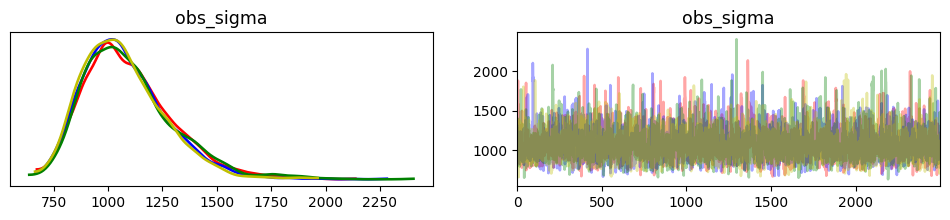

Модель: lgt_mcmc


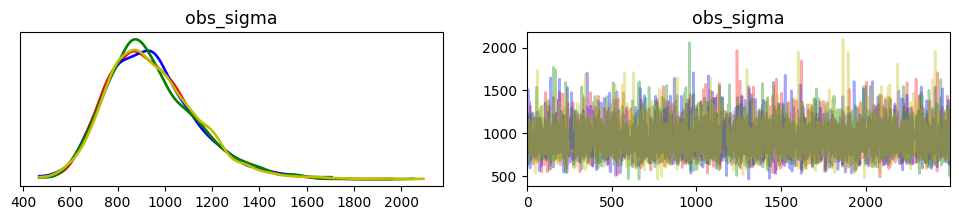

Модель: lgt_mcmc_reg


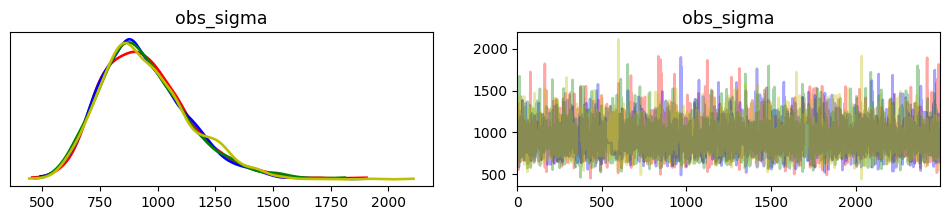

Модель: dlt_mcmc_linear


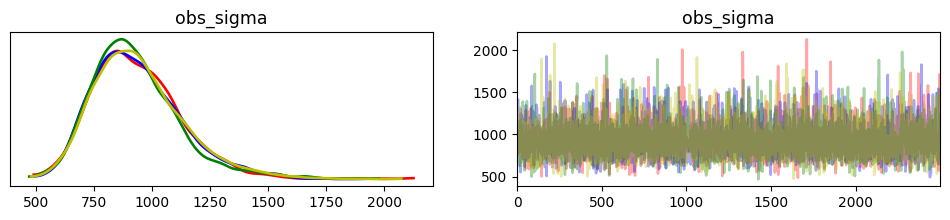

Модель: dlt_mcmc_loglinear


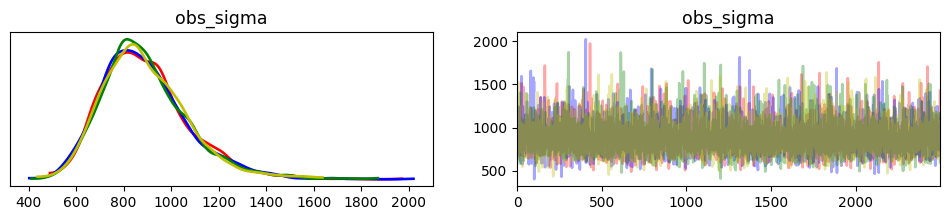

Модель: dlt_mcmc_reg_linear


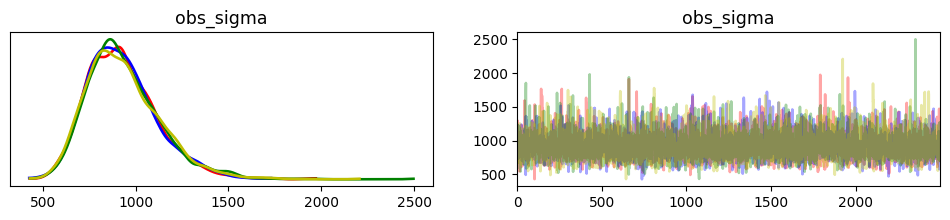

Модель: dlt_mcmc_reg_linear_ridge


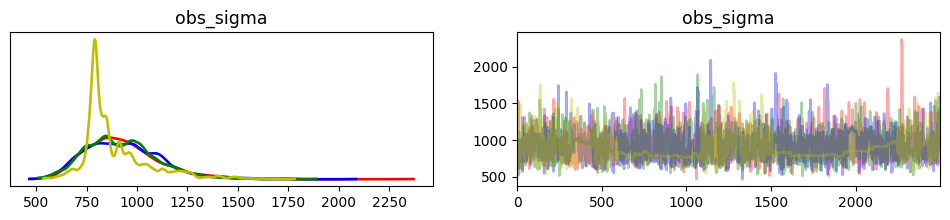

Модель: dlt_mcmc_reg_linear_lasso


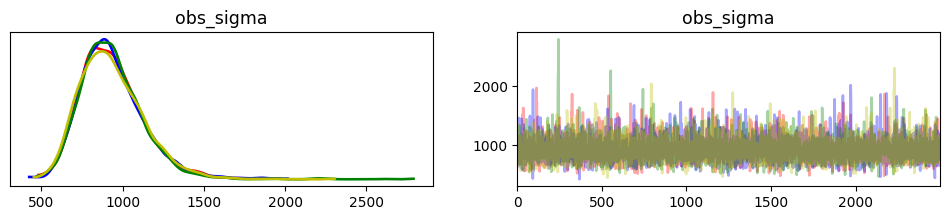

Модель: dlt_mcmc_reg_loglinear


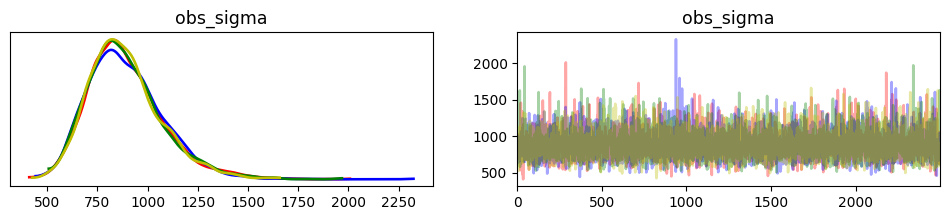

In [ ]:
for name, plot in mcmc_plots.items():
    if plot is not None:
        print(f"Model: {name}")        
        fig = plot[0][0].figure
        display(fig) 
        plt.close(fig)

**Observations:**

- Model dlt_mcmc_reg_linear_ridge (DLT with mcmc, linear trend and regressors) has a not very good plot.
- It's better not to trust its metrics.

Let's examine the metrics.

In [36]:
df_results_dau.sort_values('rolling_smape')

,model_class,estimator,has_regressors,trend_type,regression_penalty,wbic,bic,expanding_smape,expanding_wmape,expanding_mape,expanding_mse,expanding_mae,expanding_rmsse,rolling_smape,rolling_wmape,rolling_mape,rolling_mse,rolling_mae,rolling_rmsse
name,,,,,,,,,,,,,,,,,,,
dlt_map_linear,DLT,stan-map,False,linear,,NaN,"1,291.923",0.045,0.047,0.047,"1,714,451.427",898.276,1.158,0.039,0.039,0.040,"1,156,992.788",751.716,0.951
dlt_map_reg_linear,DLT,stan-map,True,linear,,NaN,"1,296.253",0.044,0.046,0.046,"1,679,536.284",885.120,1.146,0.039,0.040,0.040,"1,169,642.211",760.170,0.956
dlt_mcmc_reg_linear,DLT,stan-mcmc,True,linear,,"1,281.638",NaN,0.045,0.046,0.047,"1,551,645.937",886.006,1.101,0.041,0.041,0.042,"1,203,225.215",790.595,0.970
dlt_mcmc_reg_linear_ridge,DLT,stan-mcmc,True,linear,auto_ridge,"1,280.667",NaN,0.046,0.047,0.047,"1,582,144.484",897.954,1.112,0.041,0.042,0.042,"1,206,715.936",791.483,0.971
dlt_mcmc_linear,DLT,stan-mcmc,False,linear,,"1,281.915",NaN,0.045,0.046,0.047,"1,549,721.971",886.623,1.101,0.041,0.042,0.042,"1,208,392.630",791.902,0.972
dlt_mcmc_reg_linear_lasso,DLT,stan-mcmc,True,linear,lasso,"1,281.635",NaN,0.045,0.046,0.047,"1,540,556.175",883.680,1.097,0.041,0.042,0.042,"1,210,013.541",792.952,0.973
lgt_map,LGT,stan-map,False,,,NaN,"1,295.670",0.054,0.051,0.053,"1,513,426.190",977.693,1.088,0.050,0.048,0.049,"1,307,783.548",911.900,1.011
lgt_map_reg,LGT,stan-map,True,,,NaN,"1,299.570",0.042,0.042,0.042,"1,260,426.071",795.188,0.993,0.051,0.053,0.053,"1,927,233.359","1,018.170",1.227
lgt_mcmc_reg,LGT,stan-mcmc,True,,,"1,284.129",NaN,0.057,0.054,0.056,"1,670,009.572","1,030.569",1.143,0.052,0.050,0.051,"1,497,809.091",945.191,1.082


**Observations:**

- Linear trend shows better results than log-linear.
- MAP performs better than MCMC
    - most likely due to small data volume
    - Markov chains may not have time to converge on small data volume
- Regressors don't seem to significantly improve quality.
- Regularization doesn't lead to metric improvement.
- ETS and KTR showed worse results than LGT and DLT
- DLT clearly leads in quality.
- Ultimately, the leader is DLT model with map, without regressors, with linear trend and without regularization.
- DLT model with map, regressors, linear trend, and without regularization shows almost the same results as the leader.
- Since regressors don't improve quality, and their presence may lead to overfitting in the future, we'll choose the model without regressors.

**Which model do we choose?**

- DLT model with map, without regressors, with linear trend and without regularization.

**What are the metrics of the best model?**

- SMAPE metric in rolling backtesting has value 0.039.
    - This means the model was wrong by 3.9% on average from actual data.
    - Considering the small amount of data, this is a very good result.
- MAE metric in rolling backtesting has value 752.
    - This means the model was wrong by 752 users on average from actual data.


Let's examine the forecast for the last week in history.

In [37]:
best_model_name_dau = 'dlt_map_linear'

In [38]:
now_date = pd.Timestamp.now().date()

In [39]:
train_data = df[df.date.dt.date < now_date - pd.Timedelta(days=7)]
test_data =  df[df.date.dt.date >= now_date - pd.Timedelta(days=7)]

In [ ]:
config = models_config_dau[best_model_name_dau]
best_model_dau = config['model_class'](**config['params'])
best_model_dau.fit(train_data)
predicted_df = best_model_dau.predict(df=test_data)
plot = plot_predicted_data(df, predicted_df, "date", 'users', title=f'Prediction {best_model_name_dau}')

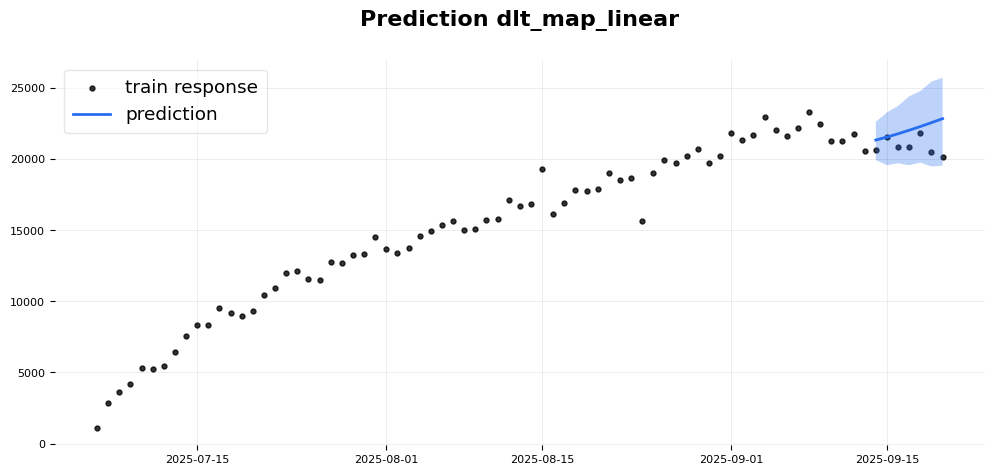

In [41]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

**Observations:**

- Some actual values didn't fall within the confidence interval. This is not good.
- However, it's worth noting that a trend break occurred this week that wasn't present in the history.
- The model isn't trained for such behavior.
- We can conclude that the model identifies trends well, backtesting evaluations are good.
- But to capture trend changes, they need to be present in the history.

Let's examine how the model predicts on past data.

In [ ]:
predicted_df = best_model_dau.predict(df=df)
plot = plot_predicted_data(df, predicted_df, "date", 'users', title=f'Prediction {best_model_name_dau}')

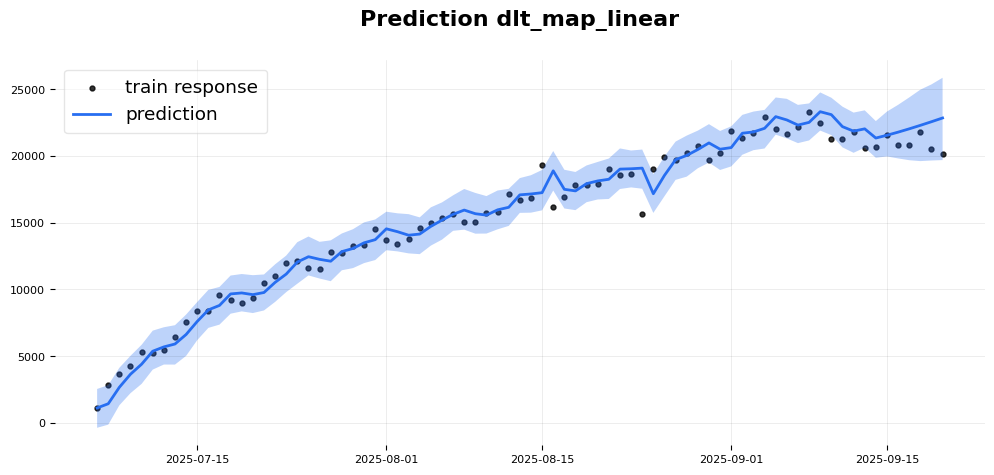

In [43]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

Let's examine how the model made forecasts during backtesting.

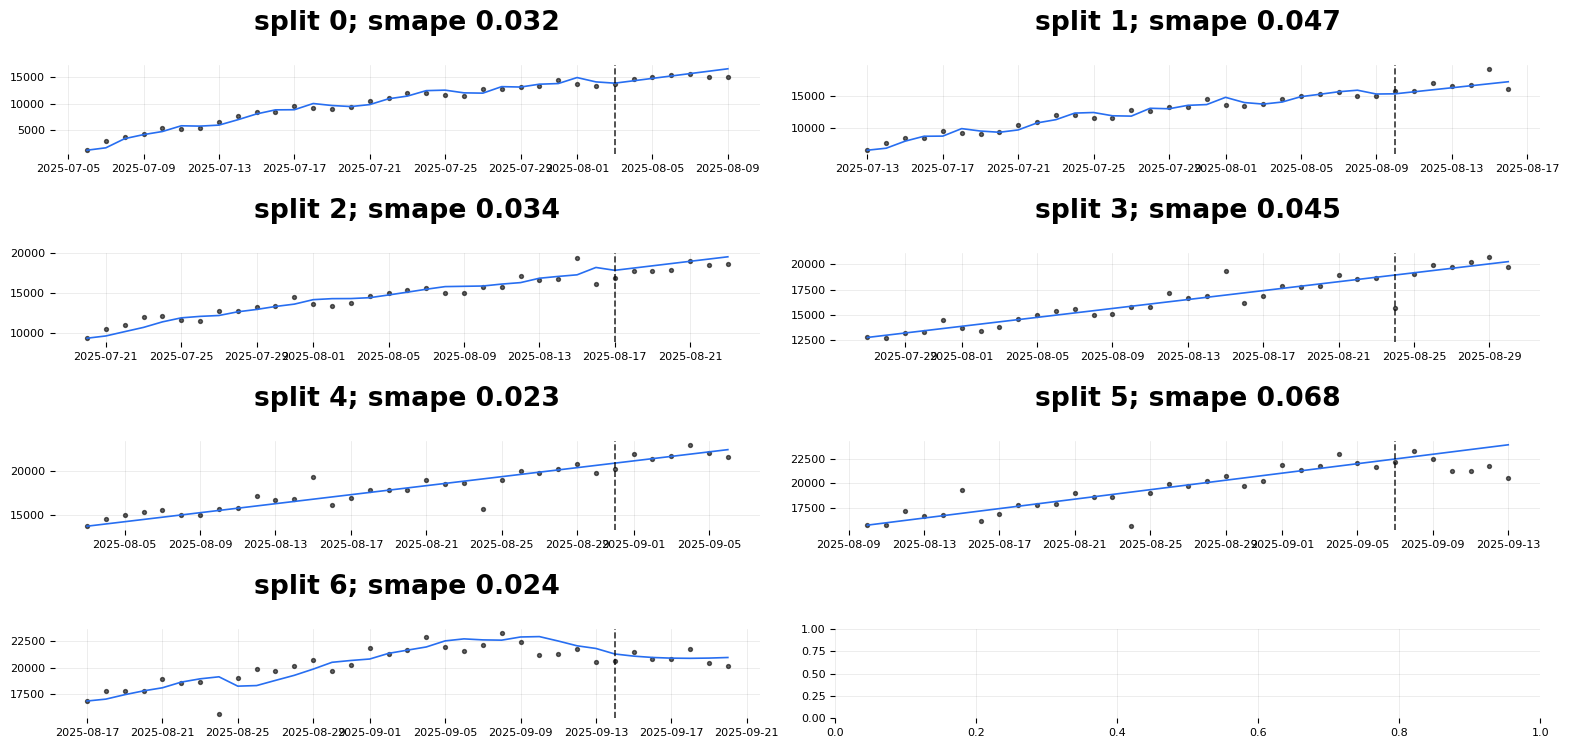

In [44]:
fig = bt_plots[best_model_name_dau][0][0].figure
display(fig) 
plt.close(fig)

**Observations:**

- Very good, which confirms the backtesting evaluations.

## Total Number of Actions

Create a dataframe for convenience.

In [48]:
models_config_actions = get_models_config('actions')

In [49]:
models_meta = []
for name, config in models_config_actions.items():
    models_meta.append({
        'name': name,
        'model_class': config['model_class'].__name__,
        'estimator': config['params'].get('estimator', ''),
        'has_regressors': 'regressor_col' in config['params'],
        'trend_type': config['params'].get('global_trend_option', ''), 
        'regression_penalty': config['params'].get('regression_penalty', '')
    })

df_results_actions = pd.DataFrame(models_meta).set_index('name')
df_results_actions

,model_class,estimator,has_regressors,trend_type,regression_penalty
name,,,,,
ets_map,ETS,stan-map,False,,
ets_mcmc,ETS,stan-mcmc,False,,
lgt_map,LGT,stan-map,False,,
lgt_mcmc,LGT,stan-mcmc,False,,
lgt_map_reg,LGT,stan-map,True,,
lgt_mcmc_reg,LGT,stan-mcmc,True,,
dlt_map_linear,DLT,stan-map,False,linear,
dlt_map_loglinear,DLT,stan-map,False,loglinear,
dlt_mcmc_linear,DLT,stan-mcmc,False,linear,


### Processing Execution

In [ ]:
print(f"Let's start the assessment {len(models_config_actions)} models")
results = []
mcmc_plots = {}
bt_plots = {}
for name, config in tqdm(models_config_actions.items()):
    result, mcmc_plot, bt_plot = evaluate_single_model(name, config, df, backtest_params)
    results.append(result)
    mcmc_plots[name] = mcmc_plot
    bt_plots[name] = bt_plot

Create final DataFrame

In [51]:
df_results = pd.DataFrame(results)
df_results.set_index('model_name', inplace=True)

Merge with meta-information.

In [52]:
df_results_actions = df_results_actions.merge(df_results, left_index=True, right_index=True, how='left')

### Results Analysis

Let's examine the results.

First, let's check if mcmc models converged.

Модель: ets_mcmc


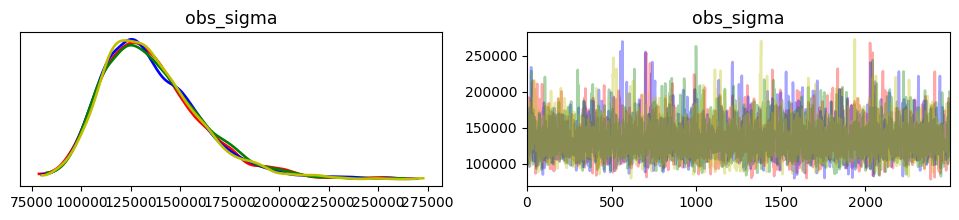

Модель: lgt_mcmc


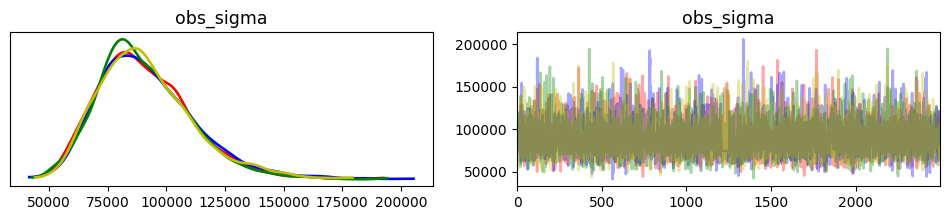

Модель: lgt_mcmc_reg


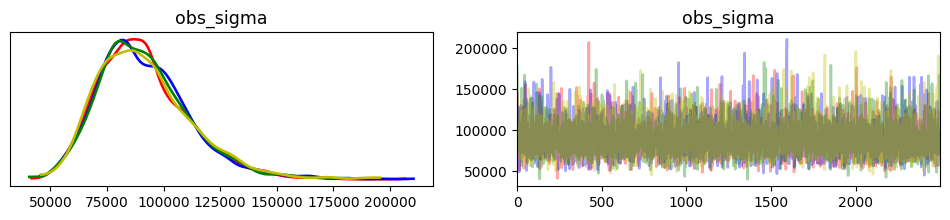

Модель: dlt_mcmc_linear


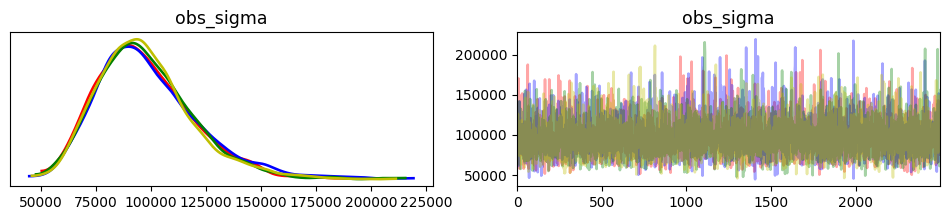

Модель: dlt_mcmc_loglinear


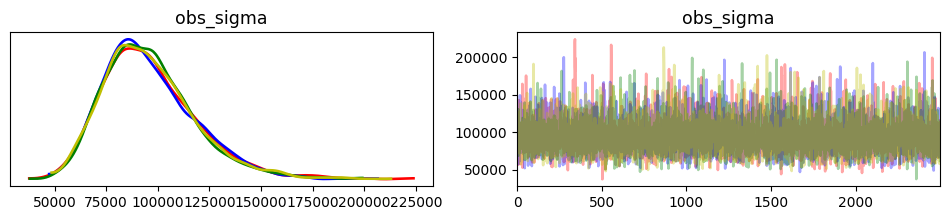

Модель: dlt_mcmc_reg_linear


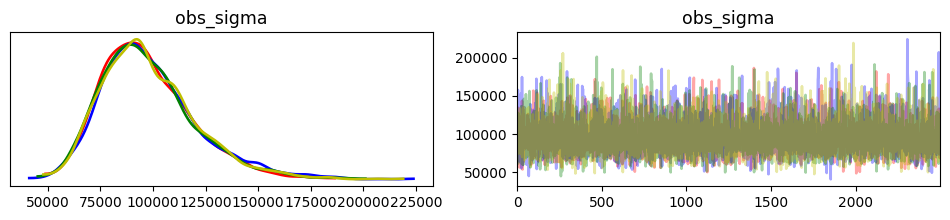

Модель: dlt_mcmc_reg_linear_ridge


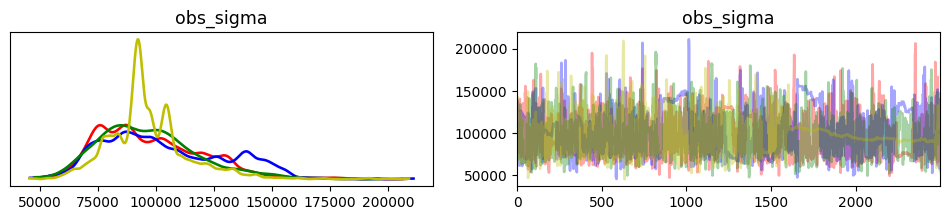

Модель: dlt_mcmc_reg_linear_lasso


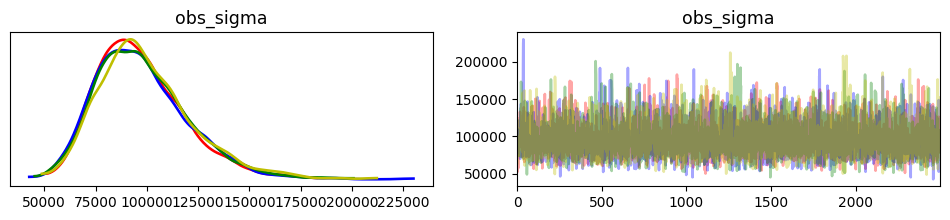

Модель: dlt_mcmc_reg_loglinear


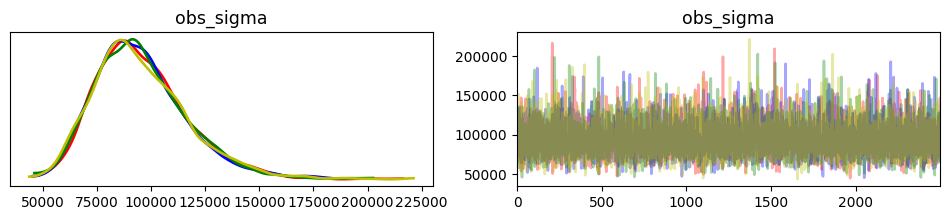

Модель: dlt_mcmc_reg_users_linear


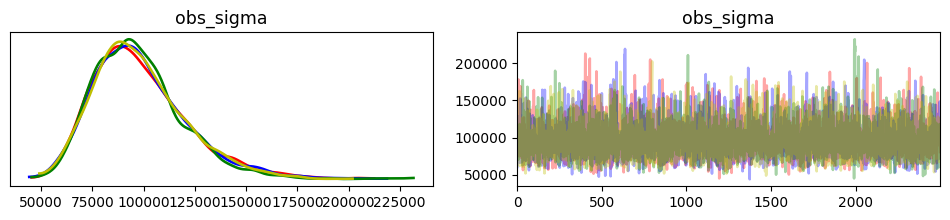

In [54]:
for name, plot in mcmc_plots.items():
    if plot is not None:
        print(f"Model: {name}")        
        fig = plot[0][0].figure
        display(fig) 
        plt.close(fig)

**Observations:**

- Model dlt_mcmc_reg_linear_ridge (DLT with mcmc, linear trend and regressors) again has a not very good plot.
- It's better not to trust its metrics.

Let's examine the metrics.

In [55]:
df_results_actions.sort_values('rolling_smape')

,model_class,estimator,has_regressors,trend_type,regression_penalty,wbic,bic,expanding_smape,expanding_wmape,expanding_mape,expanding_mse,expanding_mae,expanding_rmsse,rolling_smape,rolling_wmape,rolling_mape,rolling_mse,rolling_mae,rolling_rmsse
name,,,,,,,,,,,,,,,,,,,
dlt_map_reg_linear_ridge,DLT,stan-map,True,linear,auto_ridge,NaN,"2,038.014",0.252,0.295,0.291,"127,290,852,458.638","242,354.656",2.376,0.201,0.215,0.204,"63,715,246,069.913","176,486.122",1.681
dlt_map_linear,DLT,stan-map,False,linear,,NaN,"2,001.504",0.226,0.262,0.264,"93,249,842,876.148","215,072.747",2.033,0.214,0.249,0.247,"89,109,018,357.225","204,433.197",1.988
lgt_map,LGT,stan-map,False,,,NaN,"2,003.410",0.225,0.257,0.254,"88,978,365,759.254","211,188.854",1.986,0.225,0.257,0.251,"92,532,367,207.564","210,911.659",2.026
dlt_map_reg_users_linear,DLT,stan-map,True,linear,,NaN,"2,008.499",0.237,0.274,0.271,"103,060,834,086.444","225,181.601",2.138,0.227,0.262,0.255,"99,962,337,641.471","215,553.599",2.105
dlt_map_reg_linear,DLT,stan-map,True,linear,,NaN,"2,008.594",0.215,0.249,0.249,"89,050,458,037.604","204,722.154",1.987,0.229,0.265,0.265,"92,006,895,617.693","217,922.695",2.020
dlt_mcmc_loglinear,DLT,stan-mcmc,False,loglinear,,"2,010.483",NaN,0.230,0.264,0.261,"98,141,139,754.107","217,364.785",2.086,0.232,0.264,0.260,"94,289,401,514.194","217,089.350",2.045
dlt_mcmc_reg_loglinear,DLT,stan-mcmc,True,loglinear,,"2,010.354",NaN,0.230,0.264,0.260,"97,703,964,746.100","216,852.672",2.081,0.232,0.265,0.261,"94,953,178,001.871","217,917.049",2.052
lgt_mcmc,LGT,stan-mcmc,False,,,"2,003.999",NaN,0.236,0.270,0.267,"101,484,503,120.653","222,219.332",2.121,0.234,0.268,0.264,"101,813,015,004.603","220,611.211",2.125
lgt_mcmc_reg,LGT,stan-mcmc,True,,,"2,003.946",NaN,0.236,0.271,0.267,"101,822,678,264.013","222,504.864",2.125,0.235,0.269,0.264,"102,068,105,839.183","221,264.786",2.127


**Observations:**

- Linear trend shows better results than log-linear.
- MAP performs better than MCMC
- DLT clearly leads in quality.
- KTR showed the worst results
- Regressors and regularization slightly improve model quality
- Adding total DAU as a regressor doesn't improve the model.
- The situation is ambiguous
    - Models with higher BIC have better quality
    - High BIC is logical in this case since models with regressors and regularization are more complex.
- Ultimately, the leader is DLT model with map, regressors (without DAU regressor), linear trend and ridge regularization.
- In second place is DLT model with map, without regressors, with linear trend and without regularization.
- The choice is difficult, but we'll choose the simpler model since quality is similar and bic is lower for the simple one.

**Which model do we choose?**

- DLT model with map, without regressors, with linear trend and without regularization.

**What are the metrics of the best model?**

- SMAPE metric in rolling backtesting has value 0.214.
    - This means the model was wrong by 21.4% on average from actual data.
    - Considering the small amount of data and metric variability, this is a decent result.
- MAE metric in rolling backtesting has value 204,433.
    - This means the model was wrong by 204,433 total actions on average from actual data.

Let's examine the forecast for the last week in history.

In [56]:
best_model_name_actions = 'dlt_map_linear'

In [57]:
now_date = pd.Timestamp.now().date()

In [58]:
train_data = df[df.date.dt.date < now_date - pd.Timedelta(days=7)]
test_data =  df[df.date.dt.date >= now_date - pd.Timedelta(days=7)]

In [ ]:
config = models_config_actions[best_model_name_actions]
best_model_actions = config['model_class'](**config['params'])
best_model_actions.fit(train_data)
predicted_df = best_model_actions.predict(df=test_data)
plot = plot_predicted_data(df, predicted_df, "date", 'actions', title=f'Prediction {best_model_name_actions}')

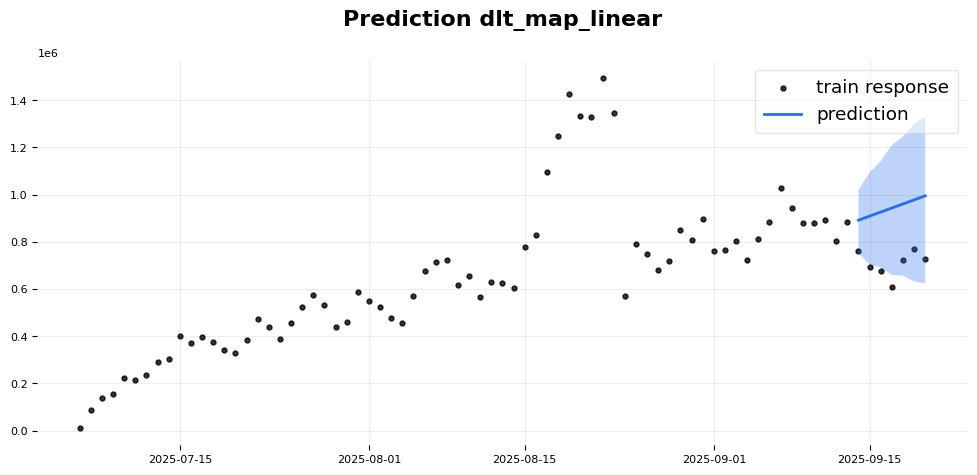

In [60]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

**Observations:**

- Some actual values didn't fall within the confidence interval. This is not good.
- However, it's worth noting that a trend break occurred this week (if we exclude the flash mob) that wasn't present in the history.
- The model isn't trained for such behavior.

Let's examine how the model predicts on past data.

In [ ]:
predicted_df = best_model_actions.predict(df=df)
plot = plot_predicted_data(df, predicted_df, "date", 'actions', title=f'Prediction {best_model_name_actions}')

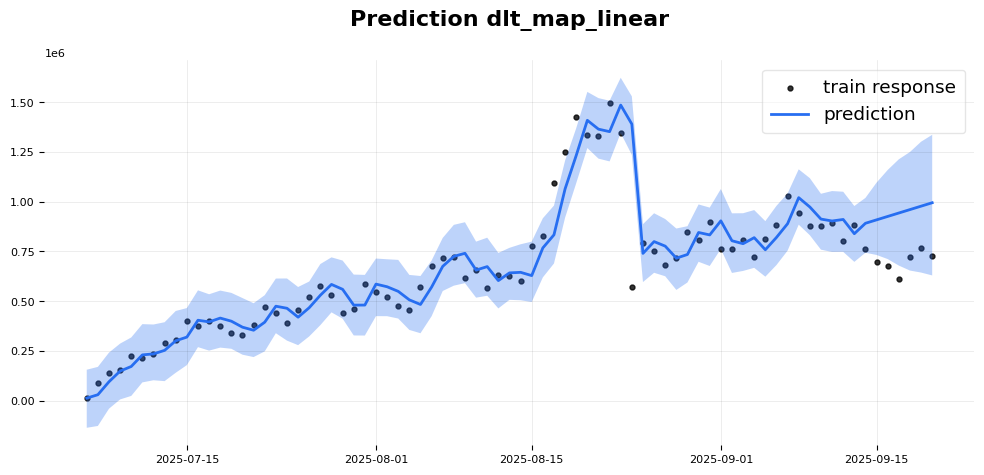

In [62]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

Let's examine how the model made forecasts during backtesting.

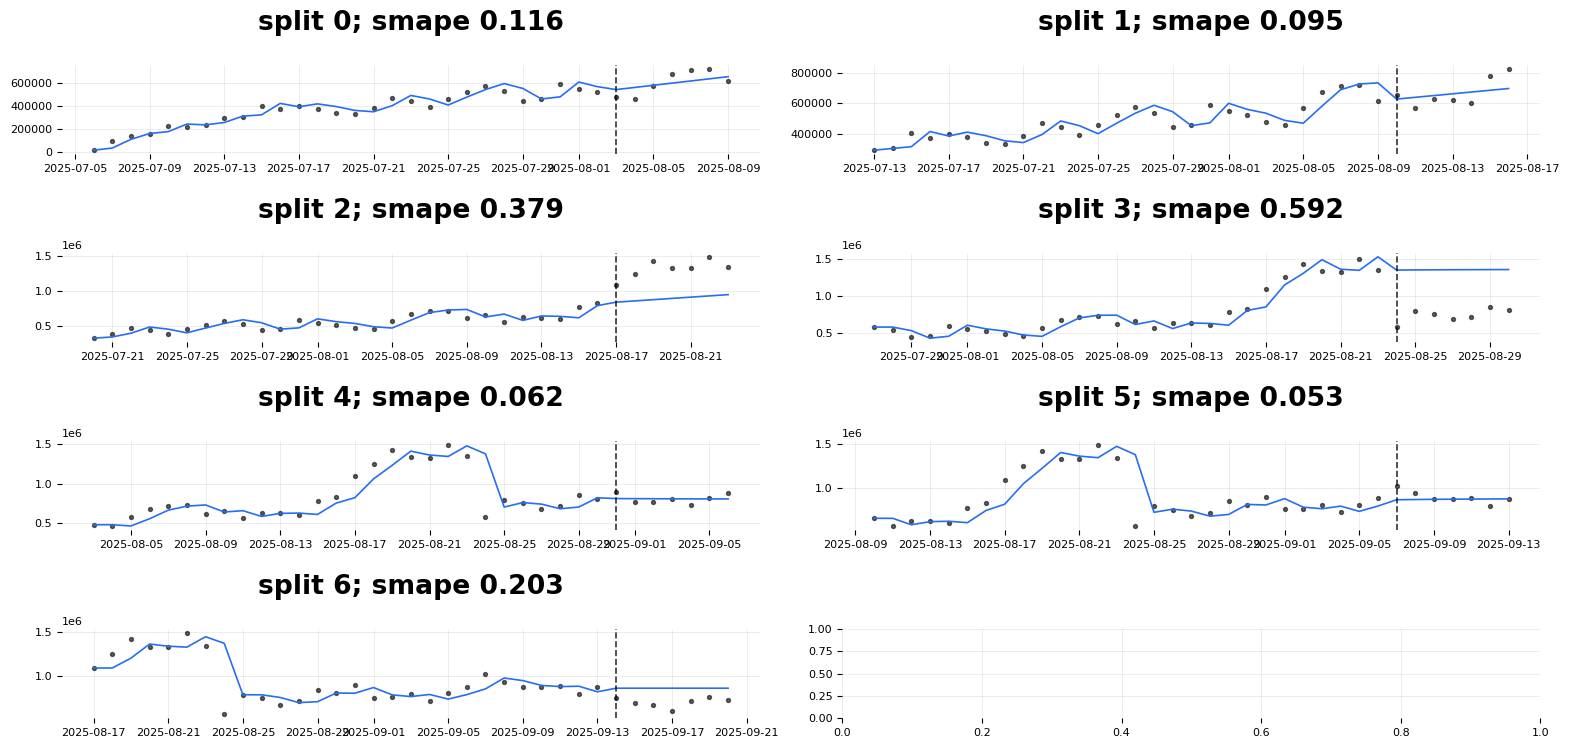

In [63]:
fig = bt_plots[best_model_name_actions][0][0].figure
display(fig) 
plt.close(fig)

**Observations:**

- Average result. Metrics confirm this.
- SMAPE metric dropped most significantly before and after the flash mob.
- The model doesn't capture sharp changes. This is logical since such movements weren't present in the history.

## Grid Search

Grid search - iterating through possible model parameters and checking which one gives the minimum error function value.

Let's do this for the trend damping parameter.

In [ ]:
grid_dict = {}
for model, model_name in [(best_model_dau, best_model_name_dau), (best_model_actions, best_model_name_actions)]:
    model_res = {}
    grid_dict[model_name] = model_res
    model_res['best_params'], model_res['tuned_df'] = grid_search_orbit(
        param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)} # our parameter
        , model=model
        , df=df
        , min_train_len=backtest_params['min_train_len']
        , incremental_len=backtest_params['incremental_len']
        , forecast_len=backtest_params['forecast_len']
        , metrics=None # look at default smape
        , criteria="min" # we say that we need minimization
        , verbose=False # don't let it print the execution process
    ) 

Let's see the results.

For total DAU.

In [67]:
grid_dict[best_model_name_dau]['best_params']

[{'damped_factor': 0.30000000000000004}]

In [68]:
grid_dict[best_model_name_dau]['tuned_df']

,damped_factor,metrics
0,0.100,0.249
1,0.200,0.238
2,0.300,0.210
3,0.400,0.221
4,0.500,0.211
5,0.600,0.223
6,0.700,0.231
7,0.800,0.226
8,0.900,0.226


**Observations:**

- damped_factor slightly affects model quality.
- but the default value gives quality close to the best, so we'll keep the default value.

For total number of actions.

In [69]:
grid_dict[best_model_name_actions]['best_params']

[{'damped_factor': 0.30000000000000004}]

In [70]:
grid_dict[best_model_name_actions]['tuned_df']

,damped_factor,metrics
0,0.100,0.249
1,0.200,0.238
2,0.300,0.210
3,0.400,0.221
4,0.500,0.211
5,0.600,0.223
6,0.700,0.231
7,0.800,0.226
8,0.900,0.226


**Observations:**

- For total number of actions, there's a small effect.
- But the default value is almost the best choice, so we'll keep the default value.

# Test Forecast

Make a test forecast.

Create a dataframe with future dates.

In [71]:
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='D')
future_df = pd.DataFrame({'date': future_dates})

Calculate regressors for the future

In [72]:
future_df['is_flashmob'] = 0
future_df['is_ads_company'] = 0
future_df['is_drop_down'] = 0

Make forecast for total DAU.

In [ ]:
predicted_df = best_model_dau.predict(df=future_df)
plot = plot_predicted_data(df, predicted_df, "date", 'users', title=f'Prediction {best_model_name_dau}')

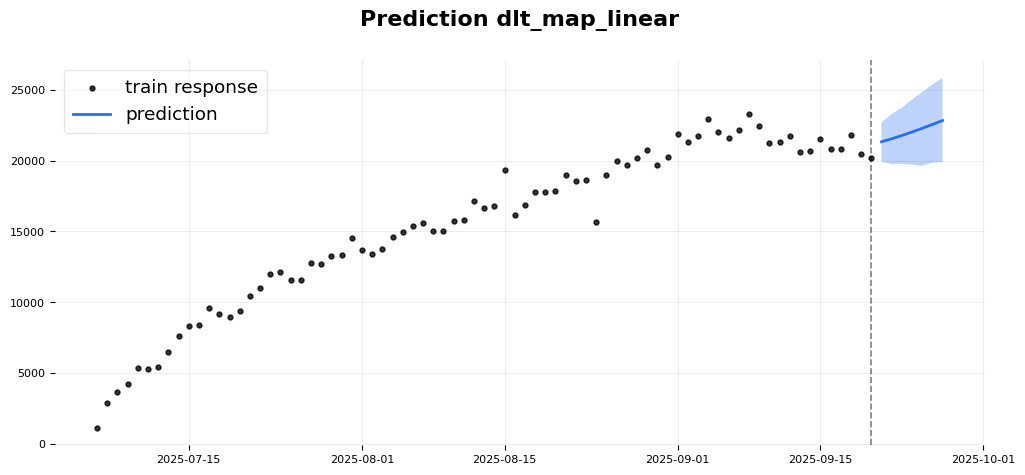

In [75]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

Make forecast for total number of actions.

In [ ]:
predicted_df = best_model_actions.predict(df=future_df)
plot = plot_predicted_data(df, predicted_df, "date", 'actions', title=f'Prediction {best_model_name_actions}')

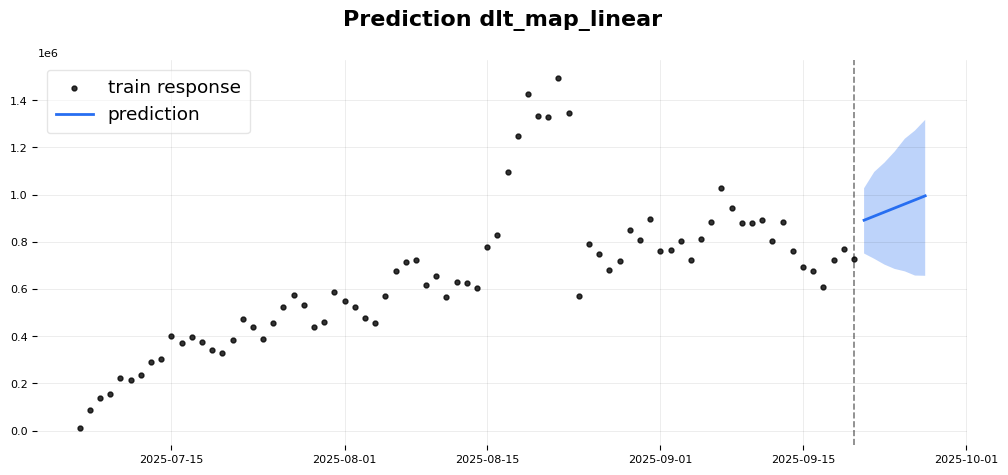

In [77]:
fig = plot.get_figure()
fig.set_size_inches(12, 5)
display(fig)

# Conclusion

## Total DAU

**Model Analysis Results**

- Linear trend shows better results than log-linear.
- MAP performs better than MCMC
    - most likely due to small data volume
    - Markov chains may not have time to converge on small data volume
- Models with mcmc converged, meaning their backtesting metrics are correct.
- Regressors don't seem to significantly improve quality.
- Regularization doesn't lead to metric improvement.
- ETS and KTR showed worse results than LGT and DLT
- DLT clearly leads in quality.
- Ultimately, the leader is DLT model without regressors with linear trend and without regularization.
- DLT model with regressors with linear trend and without regularization shows almost the same results as the leader.
- Since regressors don't improve quality, and their presence may lead to overfitting in the future, we'll choose the model without regressors.

**Best Model**

- DLT model with map, without regressors, with linear trend and without regularization.

**Best Model Metrics**

- SMAPE metric in rolling backtesting has value 0.039.
    - This means the model was wrong by 3.9% on average from actual data.
    - Considering the small amount of data, this is a very good result.
- MAE metric in rolling backtesting has value 752.
    - This means the model was wrong by 752 users on average from actual data.

## Total Number of Actions

**Model Analysis Results**

- Linear trend shows better results than log-linear.
- MAP performs better than MCMC
- DLT clearly leads in quality.
- KTR showed the worst results
- Regressors and regularization slightly improve model quality
- Adding total DAU as a regressor doesn't improve the model.
- The situation is ambiguous
    - Models with higher BIC have better quality
    - High BIC is logical in this case since models with regressors and regularization are more complex.
- Ultimately, the leader is DLT model with map, regressors (without DAU regressor), linear trend and ridge regularization.
- In second place is DLT model with map, without regressors, with linear trend and without regularization.

**Best Model**

- DLT model with map, without regressors, with linear trend and without regularizatio

**Best Model Metrics**

- SMAPE metric in rolling backtesting has value 0.214.
    - This means the model was wrong by 21.4% on average from actual data.
    - Considering the small amount of data and metric variability, this is a decent result.
- MAE metric in rolling backtesting has value 204,433.
    - This means the model was wrong by 204,433 total actions on average from actual data.


## Recommendations

- We don't have enough data for a full monthly forecast, so currently it's recommended to make weekly forecasts.
- As data accumulates, model testing should be repeated with longer forecast horizons.
- Since the app has only existed for a few months, making future predictions is difficult as user activity history hasn't accumulated.
- Moreover, a new product may behave less predictably than a long-existing product.
- Currently, it's recommended to use 2 metrics (total DAU and total number of actions) for future user activity.
- Although total number of actions is better suited for determining server load, it's also subject to strong variations that complicate forecasting.
- Total DAU behaves more predictably, leading to better forecasts.